In [1]:
ownerpath = f'/Users/lenfn/Documents/AST 443/AST 443 Group 5'

In [26]:
import os
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.io import fits
from IPython.display import Image
import math
import numpy as np

import glob
import matplotlib.colors as colors
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.visualization import make_lupton_rgb
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet
from astropy.stats import sigma_clipped_stats

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
AstrometryNet.key = 'kwbavttkhitkoaeo'

%matplotlib inline

from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install photutils

In [4]:
dark_frame = []
for i in range(10):
    filename = f'{ownerpath}/Lab 2/Darks/HAT_P_16_VISIBLE_DARK_20S_.0000000{i}.DARK.FIT'
    dark_f = fits.getdata(filename)
    dark_frame.append(dark_f)

In [5]:
master_dark_data = np.median(dark_frame, axis=0)

In [41]:
dark_frame_3 = []
for i in range(5):
    filename = f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Picture of Object/Andromena/Dark/Andromeda_Visible_Dark_3s_.0000000{i}.DARK.FIT'
    dark_f3 = fits.getdata(filename)
    dark_frame_3.append(dark_f3)

In [42]:
master_dark_data3 = np.median(dark_frame_3, axis=0)

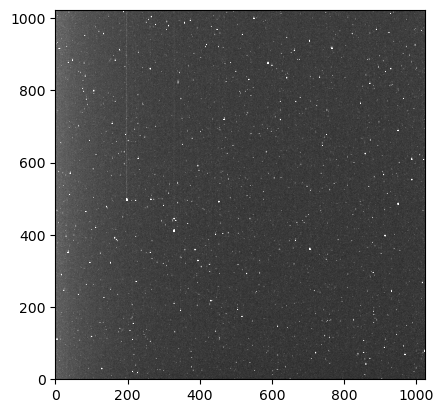

In [47]:
plt.imshow(master_dark_data3, cmap='gray', vmax=np.mean(master_dark_data3)+(np.std(master_dark_data3)), origin='lower')

In [7]:
file_num=[1,2,3,4,5,6,7,8,9]
flat_fields_data=[]

for i in range(len(file_num)):
    field_file=f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_2s_visible_.0000000{i}.FLAT.FIT'
    field_file_data=fits.open(field_file)
    flat_fields_data.append(field_file_data[0].data)

# Compute the median flat field
median_flat_field = np.median(flat_fields_data, axis=0)

In [13]:
# Normalizing the flat field
master_flat_field=median_flat_field/np.max(median_flat_field)


In [ ]:
master_flat = fits.getdata(f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/Normalized_Master_Flat-Field.FIT')

#master_flat_n = (master_flat - master_dark_data)
#master_flat_normalized = master_flat_n / np.median(master_flat_n)

In [14]:
science_files = []

for i in range(194):
    if i < 10:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.0000000{i}.FIT'
    elif i < 100 :
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.000000{i}.FIT'
    else:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.00000{i}.FIT'
    science_data = fits.getdata(filename)
    science_files.append(science_data)

In [17]:
calibrated_science_withflat = []
for i in range(194):
    science_corrected = (science_files[i] - master_dark_data)/master_flat_field
    calibrated_science_withflat.append(science_corrected)

    output_file_with = f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
    hdu = fits.PrimaryHDU(science_corrected)
    hdu.writeto(output_file_with, overwrite=True)

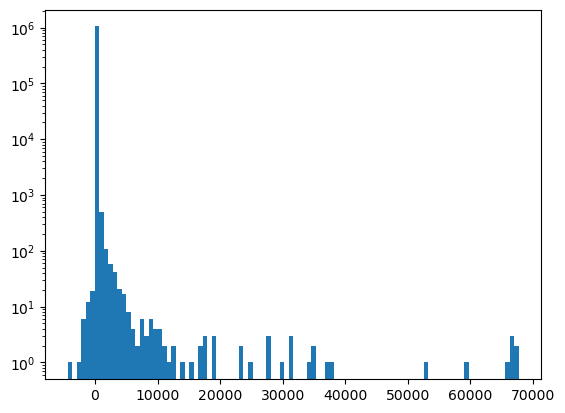

In [35]:
flatten_cal_science=calibrated_science_withflat[0].flatten()
plt.hist(flatten_cal_science, bins=100)
plt.yscale('log')

In [ ]:
# calibrated_science_withflat = []
# for i in range(194):
#     science_corrected = science_files[i] - master_dark_data
#     calibrated_data_with =  science_corrected / master_flat
#     calibrated_science_withflat.append(calibrated_data_with)

#     output_file_with = f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
#     hdu = fits.PrimaryHDU(calibrated_data_with)
#     hdu.writeto(output_file_with, overwrite=True)

In [ ]:
# calibrated_science_withoutflat = []
# for i in range(194):
#     science_corrected = science_files[i] - master_dark_data
#     calibrated_data_without =  science_corrected / np.mean(science_corrected)
#     calibrated_science_withoutflat.append(calibrated_science_withoutflat)

#     output_file_without = f'{ownerpath}/Lab 2/Subtracted Transient(withoutflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
#     hdu = fits.PrimaryHDU(calibrated_data_without)
#     hdu.writeto(output_file_without, overwrite=True)

In [ ]:
# data = fits.getdata(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.0.fits')   
# mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
# print(np.array((mean, median, std)))  

In [21]:
mean, median, std = sigma_clipped_stats(calibrated_science_withflat[0], sigma=3.0)  
print(np.array((mean, median, std))) 

[248.38998673 248.27127572  15.04731646]


In [22]:
daofind = DAOStarFinder(fwhm=10.0, threshold=10.*std)  
sources = daofind(calibrated_science_withflat[0] - median)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  
sources.pprint(max_width=76)  
sources.write(f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/sources.txt', format='ascii', overwrite=True)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ----- -----
  1    307.29     17.53      0.91       0.09 ... 0.00  137.22  1.92 -0.71
  2    974.33     30.23      0.54       0.22 ... 0.00   62.05  1.38 -0.35
  3    453.31     35.35      0.82      -0.03 ... 0.00   95.54  1.48 -0.43
  4    488.44     40.14      0.55       0.31 ... 0.00   53.06  1.12 -0.12
  5    323.26     59.80      0.86       0.25 ... 0.00  129.81  1.98 -0.74
  6    435.31     77.48      0.94      -0.17 ... 0.00  162.06  2.30 -0.90
  7     39.27    167.40      0.76      -0.09 ... 0.00 2198.05 35.64 -3.88
  8      8.31    180.77      0.76      -0.28 ... 0.00   59.53  1.03 -0.04
  9    885.40    216.41      0.98      -0.02 ... 0.00 2992.52 39.91 -4.00
 10    934.33    219.34      0.97      -0.37 ... 0.00   96.22  1.27 -0.26
...       ...       ...       ...        ... ...  ...     ...   ...   ...
 58     85.99    892.53      0.60     

In [ ]:
dir(DAOStarFinder)

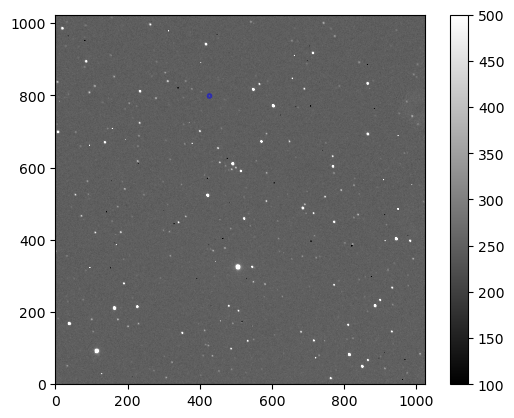

In [49]:
norm = simple_norm(calibrated_science_withflat[0], 'sqrt')

positions = np.transpose((426.9475, 798.2625))
apertures = CircularAperture(positions, r=5.0)

plt.imshow(calibrated_science_withflat[0], cmap='gray', origin='lower', vmin=100, vmax=500)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.colorbar()
plt.show()

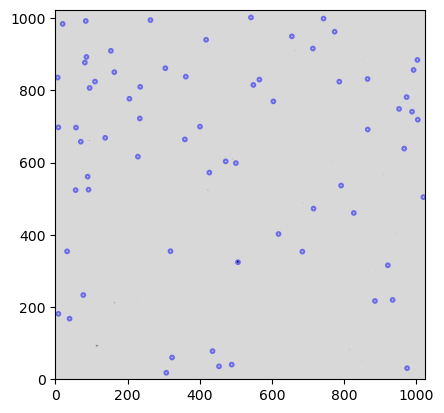

In [24]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=5.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(calibrated_science_withflat[0], cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

In [ ]:
# ast = AstrometryNet()
# ast.api_key = 'zxdmyndauvanohii'

# sources = Table.read(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/sources.txt', format='ascii')
# # Sort sources in ascending order
# sources.sort('flux')
# # Reverse to get descending order
# sources.reverse()

# image_width = 1024
# image_height = 1024
# wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
#                                         image_width, image_height, solve_timeout=120)

In [36]:
ast = AstrometryNet()
ast.api_key = 'kwbavttkhitkoaeo'

sources = Table.read(f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/sources.txt', format='ascii')
# Sort sources in ascending order
sources.sort('flux')
# Reverse to get descending order
sources.reverse()

image_width = 1024
image_height = 1024
wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                        image_width, image_height, solve_timeout=120)

Solving.......................................................................................

In [37]:
wcs_header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        9.68152412307 / RA  of reference point                         
CRVAL2  =        42.4411103366 / DEC of reference point                         
CRPIX1  =             426.94